In [1]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib as mpl

import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
def truncate_normal(input: torch.Tensor, radius):
    in_norm = input.norm(dim=1, keepdim=True)
    in_norm[in_norm > radius] = radius
    return input * in_norm / input.norm(dim=1, keepdim=True)


class PolyTailLoss(torch.nn.Module):
    def __init__(self, alpha):
        self.alpha = alpha
        super(PolyTailLoss, self).__init__()

    def forward(self, logits, target):
        return self.margin_fn(logits * target)

    def margin_fn(self, margin_vals):
        indicator = margin_vals <= 1
        inv_part = torch.pow(margin_vals, -1 * self.alpha)
        logit_inner = -1 * margin_vals
        logit_part = (torch.log(torch.exp(logit_inner) + 1)) / math.log(
            1 + math.exp(-1)
        )
        scores = logit_part * indicator + inv_part * (~indicator)
        return scores

Epoch 0: loss=0.17182354629039764
Epoch 5: loss=0.16149307787418365
Epoch 10: loss=0.14477549493312836
Epoch 15: loss=0.12612371146678925
Epoch 20: loss=0.12063088268041611
Epoch 25: loss=0.10287390649318695
Epoch 30: loss=0.09109921753406525
Epoch 35: loss=0.1499890238046646
Epoch 40: loss=0.08690794557332993
Epoch 45: loss=0.09343936294317245
Epoch 50: loss=0.0823824405670166
Epoch 55: loss=0.07551927864551544
Epoch 60: loss=0.07253291457891464
Epoch 65: loss=0.06645436584949493
Epoch 70: loss=0.09859409183263779
Epoch 75: loss=0.07557912170886993
Epoch 80: loss=0.0895298644900322
Epoch 85: loss=0.07106302678585052
Epoch 90: loss=0.09619498252868652
Epoch 95: loss=0.08494928479194641
[[('weight', array([[ 1.1947851, -1.1720512]], dtype=float32)), ('bias', array([0.3058518], dtype=float32))], [('weight', array([[ 1.7540861, -1.8875397]], dtype=float32)), ('bias', array([0.28468665], dtype=float32))], [('weight', array([[ 2.100607, -2.262811]], dtype=float32)), ('bias', array([0.282721

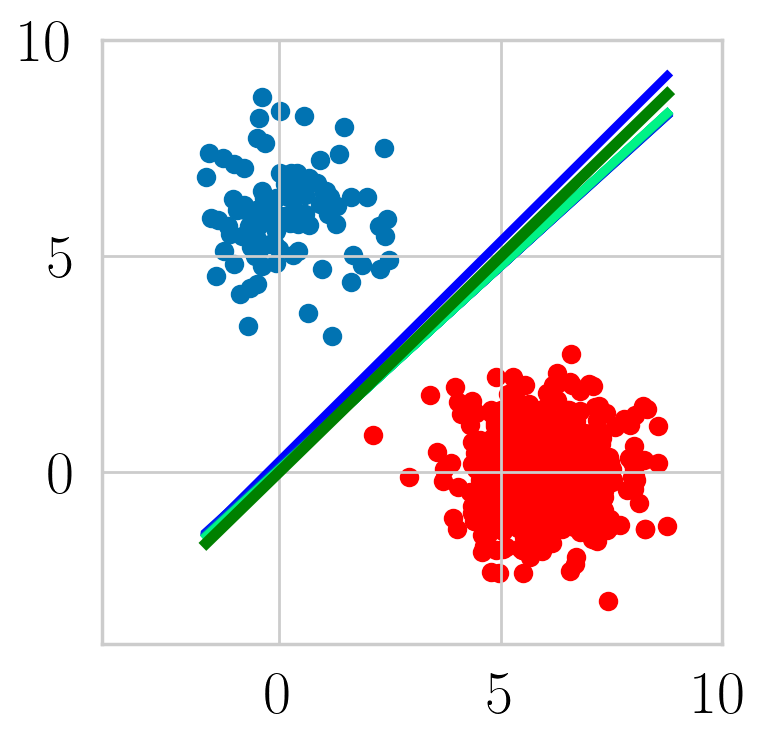

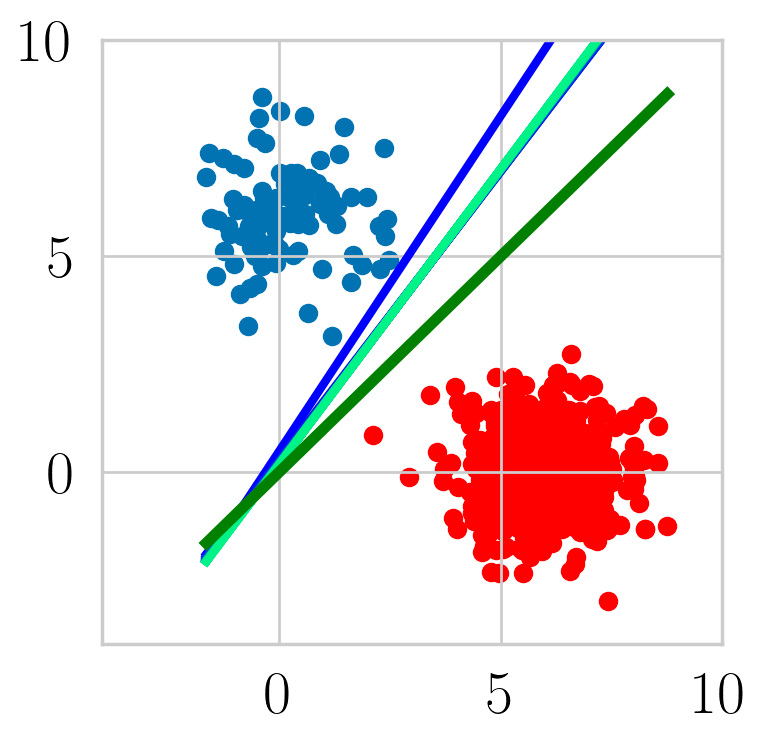

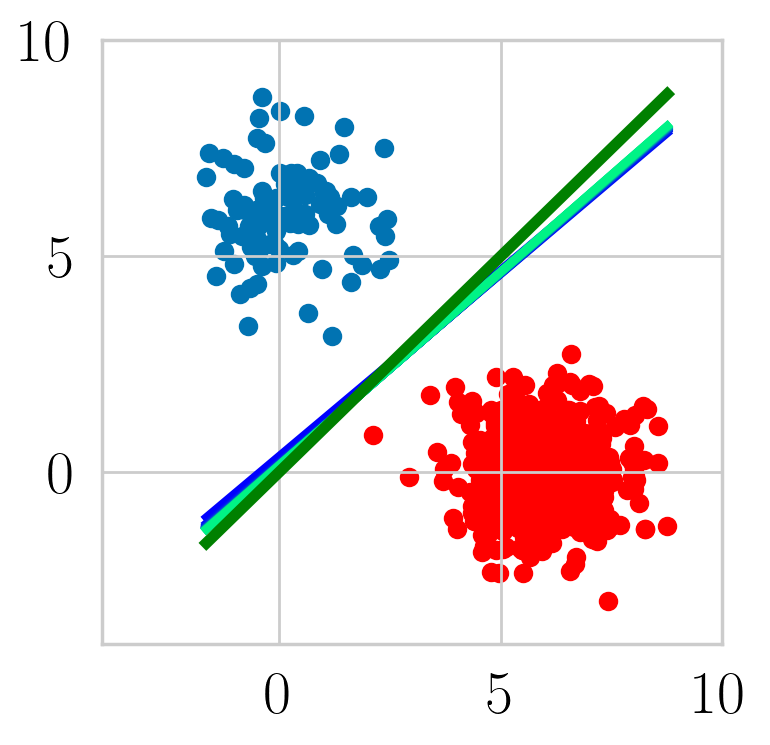

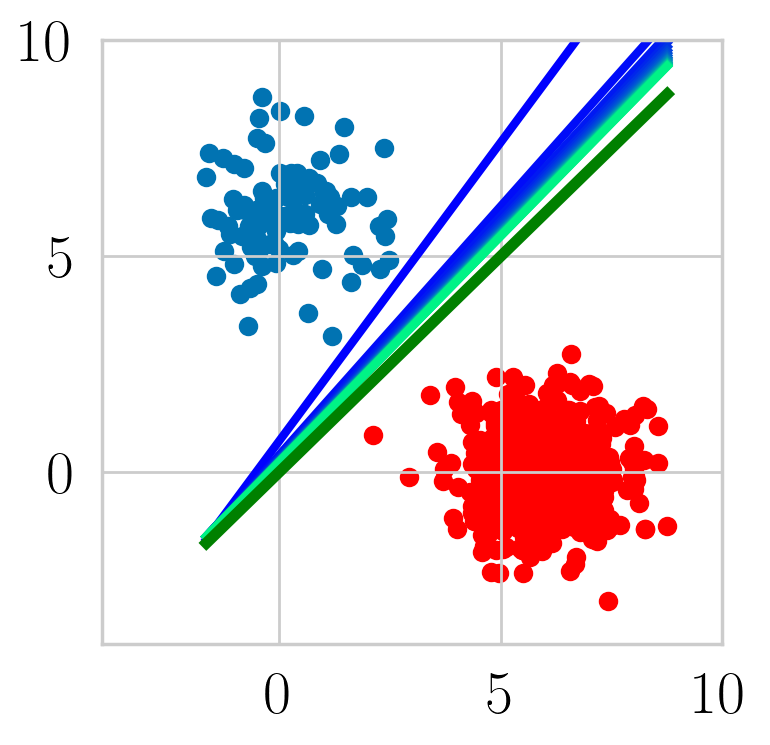

In [3]:
from itertools import product

for loss_type, weight_type in product(["poly", "logit"], ["iw", "none"]):

    torch.random.manual_seed(3)

    class_one_num = 100
    class_two_num = 500
    alpha = 1.0
    num_epochs = 100
    batch_size = 32
    lr = 0.1
    device = "cuda"


    class_one = truncate_normal(torch.randn(class_one_num, 2), 6) + torch.tensor([[0, 6]])
    class_two = truncate_normal(torch.randn(class_two_num, 2), 6) + torch.tensor([[6, 0]])

    x_seq = torch.cat((class_one, class_two), dim=0)
    y_seq = torch.cat(
        (torch.ones(class_one.shape[0]) * (-1), torch.ones(class_two.shape[0]))
    )

    dataset = torch.utils.data.TensorDataset(x_seq, y_seq)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=True
    )

    model = torch.nn.Linear(2, 1)
    model = model.to(device)

    if loss_type == "logit":
        logit_loss = torch.nn.SoftMarginLoss(reduction="none")
    else:
        logit_loss = PolyTailLoss(alpha=alpha)

    optimizer = optim.SGD(model.parameters(), lr=0.1)

    w_seq = []
    for i in range(num_epochs):
        for xs, ys in dataloader:
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()

            margin = model(xs).squeeze()
            if weight_type == "iw":
                loss_ratio = (ys > 0) + (ys < 0) * class_two_num / float(class_one_num)
            else:
                loss_ratio = torch.ones(ys.shape[0])
            loss_ratio = loss_ratio.to(device)
            loss = torch.mean(logit_loss(margin, ys) * loss_ratio)

            loss.backward()

            optimizer.step()
        if i % 5 == 0:
            print(f"Epoch {i}: loss={loss.item()}")
            w_seq.append(
                [(n, p.detach().cpu().numpy().copy()) for n, p in model.named_parameters()]
            )

    print(w_seq)

    model = model.cpu()

    xrng = np.linspace(min(x_seq[:, 0]), max(x_seq[:, 0]), num=50)


    def ymap(xseq, weight, bias):
        print(weight)
        print(bias)
        return (xseq * weight[0] + bias) / (-1 * weight[1])


    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    ax.scatter(class_one[:, 0], class_one[:, 1])
    ax.scatter(class_two[:, 0], class_two[:, 1], color="red")
    cmap = plt.cm.get_cmap("winter")
    for widx in range(len(w_seq)):
        frac_val = float(widx) / float(len(w_seq))
        print(frac_val)
        yvals = ymap(xrng, w_seq[widx][0][1][0], w_seq[widx][1][1])
        ax.plot(xrng, yvals, color=cmap(frac_val))
    ax.plot(xrng, xrng, color="green", linewidth=4)
    ax.set(ylim=(-4, 10), xlim=(-4, 10))
    fig.savefig(
        ""
        + loss_type
        + "-"
        + weight_type
        + "-"
        + str(class_one_num)
        + "-"
        + str(class_two_num)
        + ".pdf"
    )